# Behavioral Cloning - Deep Learning Model



In [16]:
### Load csv file containing image file paths and associated steering angles

import numpy as np
import tensorflow as tf
import os
import csv

DATA_DIR = '../linux_sim/DriveALL/'

samples = []
with open(DATA_DIR + 'driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        samples.append(line)

from sklearn.model_selection import train_test_split
train_samples, validation_samples = train_test_split(samples, test_size=0.2)





### Data Augmentation Functions
Functions which may be called in the batch generator below for data augmentation to increase variablity in the training set. Each function applies their transformations with randomness.

In [77]:
from numpy.random import rand

def image_offset(image):
    # Applies both a random vertical and random lateral offset to image
    # Pixels within the frame which no longer contain the image will be set to [0,0,0] (black)
    # Lateral offsets will return corresponding delta steering angle shift, no shift for vertical offsets
    
    VERT_RANGE = 50
    LAT_RANGE = 50
    
    vert_offset = (rand() - 0.5) * VERT_RANGE
    lat_offset = (rand() - 0.5) * LAT_RANGE
    
    # Delta steering angle is a linear function of lateral offset
    delta_angle = -0.001 * lat_offset
    
    # Offset image with OpenCV Translation
    rows,cols,chan = image.shape
    M = np.float32([[1,0,lat_offset],[0,1,vert_offset]])  #transformation matrix
    offset_image = cv2.warpAffine(image,M,(cols,rows))
    
    return offset_image, delta_angle
    

def image_rotate(image):
    # Rotates image by a random angle within +/-20 degrees, no steering angle change
    
    MAX_ROTATION = 20  #degrees
    
    rotation_angle = (rand() - 0.5) * 2 * MAX_ROTATION
    
    # Rotate image with OpenCV Rotation
    rows,cols,chan = image.shape
    M = cv2.getRotationMatrix2D((cols/2,rows/2), rotation_angle, 1)  #rotation matrix (about center, scale = 1)
    rotated_image = cv2.warpAffine(image,M,(cols,rows))
    
    return rotated_image


def image_flip(image):
    # Flips an image horizontally with a random probability
    # Returns sign of the steering angle due to flip/no-flip
    
    FLIP_PROB = 0.5
    
    if rand() < FLIP_PROB:
        flipped_image = cv2.flip(image,1)
        return flipped_image, -1
    else:
        return image, 1


    

### Data Preprocessing Functions
Functions to preprocess images before being input to the model

In [ ]:

def image_mask(image):
    # Masks regions of the image which may contain distracting/unnecessary content
    
    masked_image = image.copy()
    
    return masked_image

    

### Batch Generator
Loads each batch of training data as needed. Data augmentation and preprocessing will be applied as the data is loaded.

In [17]:
import cv2
import sklearn

def generator(samples, batch_size=32):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        
        sklearn.utils.shuffle(samples)
        
        # Generate batch of data
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for batch_sample in batch_samples:
                # Load image
                name = DATA_DIR+'IMG/'+batch_sample[0].split('/')[-1]
                center_image = cv2.imread(name)
                
                # Extract associated steering angle
                center_angle = float(batch_sample[3])
                
                images.append(center_image)
                angles.append(center_angle)

            # trim image to only see section with road
            
            
            
            X_train = np.array(images)
            y_train = np.array(angles)
            yield sklearn.utils.shuffle(X_train, y_train)

# compile and train the model using the generator function
train_generator = generator(train_samples, batch_size=32)
validation_generator = generator(validation_samples, batch_size=32)




### Example of augmented training data

Image Shape =  (160, 320, 3)


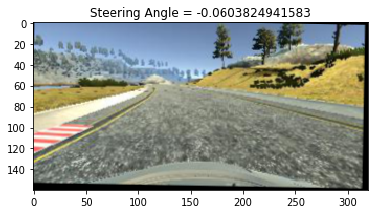

In [94]:
import matplotlib.pyplot as plt
%matplotlib inline

#a,b = next(train_generator)
print('Image Shape = ',np.shape(a[0]))
#print(a)
#print(b)
bgr_image = (cv2.split(a[0]))
rgb_image = cv2.merge(bgr_image[::-1])

rgb_image, delta_angle = image_offset(rgb_image)
rgb_image = image_rotate(rgb_image)
rgb_image, sign_angle = image_flip(rgb_image)
plt.imshow(rgb_image)
plt.title('Steering Angle = ' + str(sign_angle * (b[0] + delta_angle)))
plt.show()

### Keras Model Definition


In [ ]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.layers import Cropping2D


row, col, ch = 160, 320, 3  # Trimmed image format

model = Sequential()

# Preprocess incoming data, centered around zero with small standard deviation 
model.add(Lambda(lambda x: x/127.5 - 1.,
        input_shape=(row, col, ch),
        output_shape=(row, col, ch)))

model.add(Cropping2D(cropping=((50,20), (0,0)), input_shape=(3,160,320)))


model.add(Convolution2D(32, 3, 3, input_shape=(32, 32, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.5))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dense(5))
model.add(Activation('softmax'))



### Model Training

In [ ]:

model.compile(loss='mse', optimizer='adam')
history = model.fit_generator(train_generator, samples_per_epoch= /
            len(train_samples), validation_data=validation_generator, /
            nb_val_samples=len(validation_samples), nb_epoch=3, verbose=1)

In [ ]:
### print the keys contained in the history object
print(history_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

In [ ]:
from sklearn.preprocessing import LabelBinarizer
label_binarizer = LabelBinarizer()
y_one_hot = label_binarizer.fit_transform(y_train)

model.compile('adam', 'categorical_crossentropy', ['accuracy'])
history = model.fit(X_normalized, y_one_hot, nb_epoch=10, validation_split=0.2)

with open('small_test_traffic.p', 'rb') as f:
    data_test = pickle.load(f)

X_test = data_test['features']
y_test = data_test['labels']

# preprocess data
X_normalized_test = np.array(X_test / 255.0 - 0.5 )
y_one_hot_test = label_binarizer.fit_transform(y_test)

print("Testing")

# TODO: Evaluate the test data in Keras Here
metrics = model.evaluate(X_normalized_test,y_one_hot_test)
# TODO: UNCOMMENT CODE
for metric_i in range(len(model.metrics_names)):
    metric_name = model.metrics_names[metric_i]
    metric_value = metrics[metric_i]
    print('{}: {}'.format(metric_name, metric_value))